# HiFIC Demo
Compress arbitrary images in Colab using a pretrained neural compression model. This is a Pytorch port of the [High-Fidelity Image Compression](https://hific.github.io/) project - see the [Github repo](https://github.com/Justin-Tan/high-fidelity-generative-compression) for the source.

Execute all cells in sequence to see the results of compression on a default image, or upload your own images to be compressed by following the steps in the notebook.

Some sample reconstructions from the compressed format can be found [here](https://github.com/Justin-Tan/high-fidelity-generative-compression/blob/master/assets/EXAMPLES.md). For detailed usage instructions please see [the user's guide](https://github.com/Justin-Tan/high-fidelity-generative-compression/blob/master/assets/USAGE_GUIDE.md).


## Setup Colab Environment

In [1]:
import torch
import numpy as np

import os
import glob
import urllib
import zipfile
import collections

from google.colab import files
from PIL import Image
from IPython.display import Image as DisplayImage
from IPython.display import Javascript
from IPython.core.display import display, HTML

INPUT_DIR = '/content/files'
STAGING_DIR = '/content/stage'
OUT_DIR = '/content/out'
CKPT_DIR = '/content/checkpoint'
DEFAULT_IMAGE_PREFIX = ('https://storage.googleapis.com/hific/clic2020/images/originals/')

File = collections.namedtuple('File', ['output_path', 'compressed_path',
                                       'num_bytes', 'bpp'])

_ = [os.makedirs(dir, exist_ok=True) for dir in (INPUT_DIR, STAGING_DIR, OUT_DIR,
                                                 CKPT_DIR)]
original_sizes = dict()

In [2]:
def get_default_image(output_dir, image_choice="portrait"):
    image_ID = dict(cafe="b1b8f33917a40c9d0b118ef801de67d4.png",
                    cat="4fa92b8ecb4ee46a942837447de1ac5c.png",
                    city="b98ec5b29d02ef65e57d23ef90660b4d.png",
                    clocktower="9cbf2594f339c0d3d0f0ea25c62af52b.png",
                    fresco="8181526d9f238726d3e1d3ec3cc56fb7.png",
                    islet="c6658d87c608b631f5cc3fb5a8d89731.png",
                    mountain="d3688a7285d7b2b81febe1cd72e6e22c.png",
                    pasta="f5be5054c01d8efc834d78a991356ad6.png",
                    pines="e903c4f4684100a6dbac1f0b9b4de760.png",
                    plaza="d78b363974ac79908b79012f48de715d.png",
                    portrait="ad249bba099568403dc6b97bc37f8d74.png",
                    shoreline="b9bad0c68eb9ce94e02e9698c8cc429a.png",
                    street="90b622e11ecc37edd42297427403ee81.png",
                    tundra="cc831c904a314a0e98530124526e930b.png",
                    )[image_choice]

    default_image_url = os.path.join(DEFAULT_IMAGE_PREFIX, image_ID)
    output_path = os.path.join(output_dir, os.path.basename(default_image_url))
    print('Downloading', default_image_url, '\n->', output_path)
    urllib.request.urlretrieve(default_image_url, output_path)

def get_model_checkpoint(output_dir, model_ID, model_choice, alternative=False,
                         overwrite=False):
    output_path = os.path.join(output_dir, f'{model_choice.lower()}.pt')
    if overwrite is True:
        print('Overwriting file, if it exists.')
        !rm -v $output_path
    else:
        if os.path.exists(output_path):
            print('File already exists at', '\n->', output_path)
            return output_path
    print('Downloading model to', '\n->', output_path)
    if alternative is True:
        !wget "https://zenodo.org/record/4026003/files/$model_ID" -O $output_path
    else:
        !wget -q --show-progress --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$model_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$model_ID" -O $output_path && rm -rf /tmp/cookies.txt

    return output_path

## Select Model
Higher bitrates result in higher-fidelity reconstructions, at the expense of increased message length. `HIFIC-low` is the model with the highest compression ratio (lowest output filesize), and `HIFIC-high` is the model with the lowest compression ratio.

In [3]:
# Enter choice to right
model_choice = 'HIFIC-med' #@param ["HIFIC-low", "HIFIC-med", "HIFIC-high"]


Clone repo and grab the model checkpoint (around 2 GB). Please check the downloaded filesize carefully - see below.

In [4]:
# Drive IDs
model_choices = {'HIFIC-low': '1hfFTkZbs_VOBmXQ-M4bYEPejrD76lAY9',
                 'HIFIC-med': '1QNoX0AGKTBkthMJGPfQI0dT0_tnysYUb',
                 'HIFIC-high': '1BFYpvhVIA_Ek2QsHBbKnaBE8wn1GhFyA'}

model_ID = model_choices[model_choice]
model_path = get_model_checkpoint(CKPT_DIR, model_ID, model_choice)
first_model_init = False

-> /content/checkpoint/hific-med.pt
/content/checkpoint 100%[===================>]   1.69G  68.1MB/s    in 30s     


In [5]:
# Checkpoints should be around 2GB in size - if not, run the next
# cell to download models from an alternate host
!ls -ltrh /content/checkpoint

total 1.7G
-rw-r--r-- 1 root root 1.7G Aug 28  2020 hific-med.pt


During periods of high traffic the download quota for Google Drive may be temporarily exceeded. Please check (`ls -ltrh /content/checkpoint`) if the checkpoints are around 1.5GB - 2 GB in size. If the filesize is in kB, run the cell below this to download the model checkpoints from Zenodo - this may be slower but more robust.

In [6]:
# Don't run this if the download from Drive was successful!
model_choices = {'HIFIC-low': 'hific_low.pt?download=1',
                 'HIFIC-med': 'hific_med.pt?download=1',
                 'HIFIC-high': 'hific_hi.pt?download=1'}

model_ID = model_choices[model_choice]
model_path = get_model_checkpoint(CKPT_DIR, model_ID, model_choice,
                                  alternative=True, overwrite=True)
first_model_init = False

Overwriting file, if it exists.
removed '/content/checkpoint/hific-med.pt'
-> /content/checkpoint/hific-med.pt
--2023-12-14 04:40:25--  https://zenodo.org/record/4026003/files/hific_med.pt?download=1
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/4026003/files/hific_med.pt [following]
--2023-12-14 04:40:26--  https://zenodo.org/records/4026003/files/hific_med.pt
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1813144167 (1.7G) [application/octet-stream]
Saving to: ‘/content/checkpoint/hific-med.pt’

/content/checkpoint 100%[===================>]   1.69G  17.0MB/s    in 1m 45s  

2023-12-14 04:42:12 (16.5 MB/s) - ‘/content/checkpoint/hific-med.pt’ saved [1813144167/1813144167]



In [7]:
# Checkpoints should be around 2GB in size
!ls -ltrh /content/checkpoint

total 1.7G
-rw-r--r-- 1 root root 1.7G Dec 14 04:42 hific-med.pt


In [8]:
!pip install scikit-image==0.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.3/32.3 MB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-image: filename=scikit_image-0.15.0-cp310-cp310-linux_x86_64.whl size=47104477 sha256=ab37d7e332064d4c2f48483341862c1c75d82f2fe18f852e6a450c664367ddd2
  Stored in directory: /root/.cache/pip/wheels/fa/1f/4d/5f9eccc2af9e10e17a982d8fdc0f4e5534ae28dde315821629
Successfully built scikit-image
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.3.1 requires scikit-image>=0.16.1, but you have scikit-image 0.15.0 which is incompatible.


In [9]:
!git clone https://github.com/Justin-Tan/high-fidelity-generative-compression.git
%cd high-fidelity-generative-compression/
from compress import prepare_model, prepare_dataloader, compress_and_save, load_and_decompress, compress_and_decompress

Cloning into 'high-fidelity-generative-compression'...
remote: Enumerating objects: 1804, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 1804 (delta 15), reused 24 (delta 14), pack-reused 1775
Receiving objects: 100% (1804/1804), 86.07 MiB | 15.32 MiB/s, done.
Resolving deltas: 100% (1231/1231), done.
/content/high-fidelity-generative-compression


## Prepare Images

To upload your own images (JPG or PNG without alpha channels), set `custom_image=True` in the following cell. Otherwise, we'll use a default image from the CLIC2020 Compression Challenge dataset.

Alternatively, you can use the `Files` tab on the left and select the `Upload to session storage` icon to upload more custom images.

In [10]:
custom_image = False #@param ["False", "True"] {type:"raw"}

In [11]:
# Choose default images from CLIC2020 dataset
# Skip if uploading custom images
default_image = "portrait" #@param ["cafe", "cat", "city", "clocktower", "fresco", "islet", "mountain", "pasta", "pines", "plaza", "portrait", "shoreline", "street", "tundra"]

Using default image.
-> /content/files/ad249bba099568403dc6b97bc37f8d74.png
Got following files (1):
-> ad249bba099568403dc6b97bc37f8d74.png:


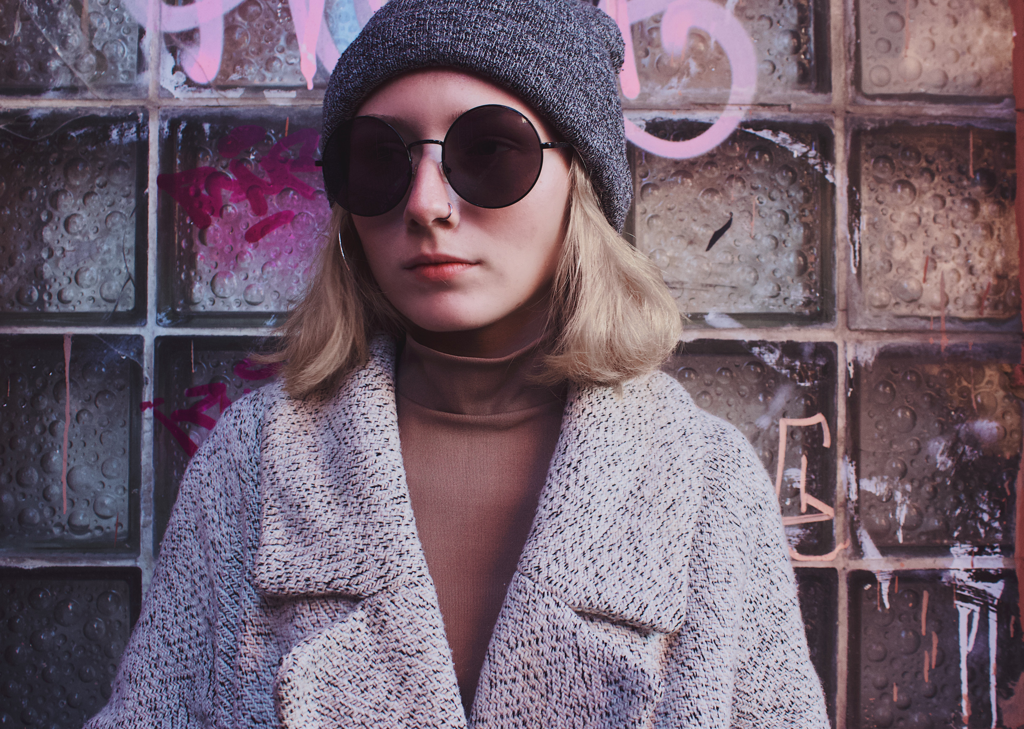

In [12]:
if custom_image is True:
    print('Using user-defined images.')
    # Get dict of upload files
    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
        !mv -iv $fn $INPUT_DIR
else:
    print('Using default image.')
    # Download default image
    get_default_image(INPUT_DIR, default_image)

all_files = os.listdir(INPUT_DIR)
print(f'Got following files ({len(all_files)}):')
scale_factor = 2 if len(all_files) == 1 else 4

for file_name in all_files:
    img = Image.open(os.path.join(INPUT_DIR, file_name))
    w, h = img.size
    img = img.resize((w // scale_factor, h // scale_factor))
    print('-> ' + file_name + ':')
    display(img)

In [13]:
SUPPORTED_EXT = {'.png', '.jpg'}

all_files = os.listdir(INPUT_DIR)
if not all_files:
    raise ValueError("Please upload/download images!")

def get_bpp(image_dimensions, num_bytes):
    w, h = image_dimensions
    return num_bytes * 8 / (w * h)

def has_alpha(img_p):
    im = Image.open(img_p)
    return im.mode == 'RGBA'

!rm -v $STAGING_DIR/*

for file_name in all_files:
    if os.path.isdir(file_name):
        continue
    if not any(file_name.endswith(ext) for ext in SUPPORTED_EXT):
        print('Skipping non-image', file_name, '...')
        continue
    full_path = os.path.join(INPUT_DIR, file_name)
    if has_alpha(full_path) is True:
        print('Skipping because of alpha channel:', file_name)
        continue

    file_name, _ = os.path.splitext(file_name)
    original_sizes[file_name] = os.path.getsize(full_path)
    output_path = os.path.join(OUT_DIR, f'{file_name}.png')
    !mv -v $full_path $STAGING_DIR

rm: cannot remove '/content/stage/*': No such file or directory
renamed '/content/files/ad249bba099568403dc6b97bc37f8d74.png' -> '/content/stage/ad249bba099568403dc6b97bc37f8d74.png'


## Enabling GPU

GPU should be enabled for this Colab. If the next cell prints a warning, do the following:
- Navigate to `Edit →> Notebook Settings`
- Select GPU from the Hardware Accelerator drop-down


In [14]:
if torch.cuda.is_available() is False:
  print('WARNING: No GPU found. Compression/decompression will be slow!')
else:
  print(f'Found GPU {torch.cuda.get_device_name(0)}')

Found GPU Tesla T4


# Compress Images
Note: Models can take up to a minute to load on Colab, depending on the allocated GPU and chosen model - you only need to run the following cell once per session.



In [15]:
# Setup model
if first_model_init is False:
    print('Building model ...')
    model, args = prepare_model(model_path, STAGING_DIR)
    first_model_init = True

04:51:33 INFO - logger_setup: /content/high-fidelity-generative-compression/compress.py
INFO:src.helpers.utils:/content/high-fidelity-generative-compression/compress.py


Building model ...
Building prior probability tables...


100%|██████████| 64/64 [00:16<00:00,  3.93it/s] 
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up Perceptual loss...


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 101MB/s] 
04:52:02 INFO - load_model: Loading model ...
INFO:src.helpers.utils:Loading model ...
04:52:02 INFO - load_model: Estimated model size (under fp32): 593.146 MB
INFO:src.helpers.utils:Estimated model size (under fp32): 593.146 MB
04:52:02 INFO - load_model: Model init 28.945s
INFO:src.helpers.utils:Model init 28.945s


Loading model from: /content/high-fidelity-generative-compression/src/loss/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


04:52:02 INFO - prepare_model: Model loaded from disk.
INFO:src.helpers.utils:Model loaded from disk.
04:52:02 INFO - prepare_model: Building hyperprior probability tables...
INFO:src.helpers.utils:Building hyperprior probability tables...
100%|██████████| 320/320 [00:00<00:00, 2141.20it/s]
04:52:09 INFO - prepare_model: All tables built.
INFO:src.helpers.utils:All tables built.


Encode images and save compressed format to disk. Note: depending on the allocated GPU, large images (`>~ 4000x4000 px`) may throw an OOM error.

In [16]:
%%time
data_loader = prepare_dataloader(args, STAGING_DIR, OUT_DIR)
compress_and_save(model, args, data_loader, OUT_DIR)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
04:52:09 INFO - compress_and_save: Starting compression...
INFO:src.helpers.utils:Starting compression...


Input images
['/content/stage/ad249bba099568403dc6b97bc37f8d74.png']


  0%|          | 0/1 [00:00<?, ?it/s]

Symbol compressed to 45536.000 bits.


04:52:21 INFO - compress: [ESTIMATED]
INFO:src.helpers.utils:[ESTIMATED]
04:52:21 INFO - compress: BPP: 0.322
INFO:src.helpers.utils:BPP: 0.322
04:52:21 INFO - compress: HL BPP: 0.008
INFO:src.helpers.utils:HL BPP: 0.008
04:52:21 INFO - compress: L BPP: 0.313
INFO:src.helpers.utils:L BPP: 0.313
04:52:21 INFO - compress: [ATTAINED]
INFO:src.helpers.utils:[ATTAINED]
04:52:21 INFO - compress: BPP: 0.334
INFO:src.helpers.utils:BPP: 0.334
04:52:21 INFO - compress: HL BPP: 0.015
INFO:src.helpers.utils:HL BPP: 0.015
04:52:21 INFO - compress: L BPP: 0.319
INFO:src.helpers.utils:L BPP: 0.319
04:52:21 INFO - compress_and_save: Attained: 0.334 bpp vs. theoretical: 0.322 bpp.
INFO:src.helpers.utils:Attained: 0.334 bpp vs. theoretical: 0.322 bpp.
100%|██████████| 1/1 [00:12<00:00, 12.01s/it]

Symbol compressed to 951712.000 bits.


100%|██████████| 1/1 [00:12<00:00, 12.21s/it]

CPU times: user 7.88 s, sys: 977 ms, total: 8.85 s
Wall time: 12.2 s


In [17]:
# Check compressed filesizes
!ls -ltrh $OUT_DIR

total 124K
-rw-r--r-- 1 root root 122K Dec 14 04:52 ad249bba099568403dc6b97bc37f8d74_compressed.hfc


Load compressed format from disk and decode

In [18]:
all_outputs = []

for compressed_file in glob.glob(os.path.join(OUT_DIR, '*.hfc')):
    file_name, _ = os.path.splitext(compressed_file)
    output_path = os.path.join(OUT_DIR, f'{file_name}.png')

    # Model decode
    reconstruction = load_and_decompress(model, compressed_file, output_path)

    all_outputs.append(File(output_path=output_path,
                            compressed_path=compressed_file,
                            num_bytes=os.path.getsize(compressed_file),
                            bpp=get_bpp(Image.open(output_path).size, os.path.getsize(compressed_file))))

torch.cuda.empty_cache()

04:52:41 INFO - load_and_decompress: Decoding time: 19.88 s
INFO:src.helpers.utils:Decoding time: 19.88 s
04:52:41 INFO - load_and_decompress: Reconstruction saved to /content/out/ad249bba099568403dc6b97bc37f8d74_compressed.png
INFO:src.helpers.utils:Reconstruction saved to /content/out/ad249bba099568403dc6b97bc37f8d74_compressed.png


# Show output

<IPython.core.display.Javascript object>

Showing /content/out/ad249bba099568403dc6b97bc37f8d74_compressed.png | 124 kB (compressed) | 0.3339 bpp | Original: 5232 kB


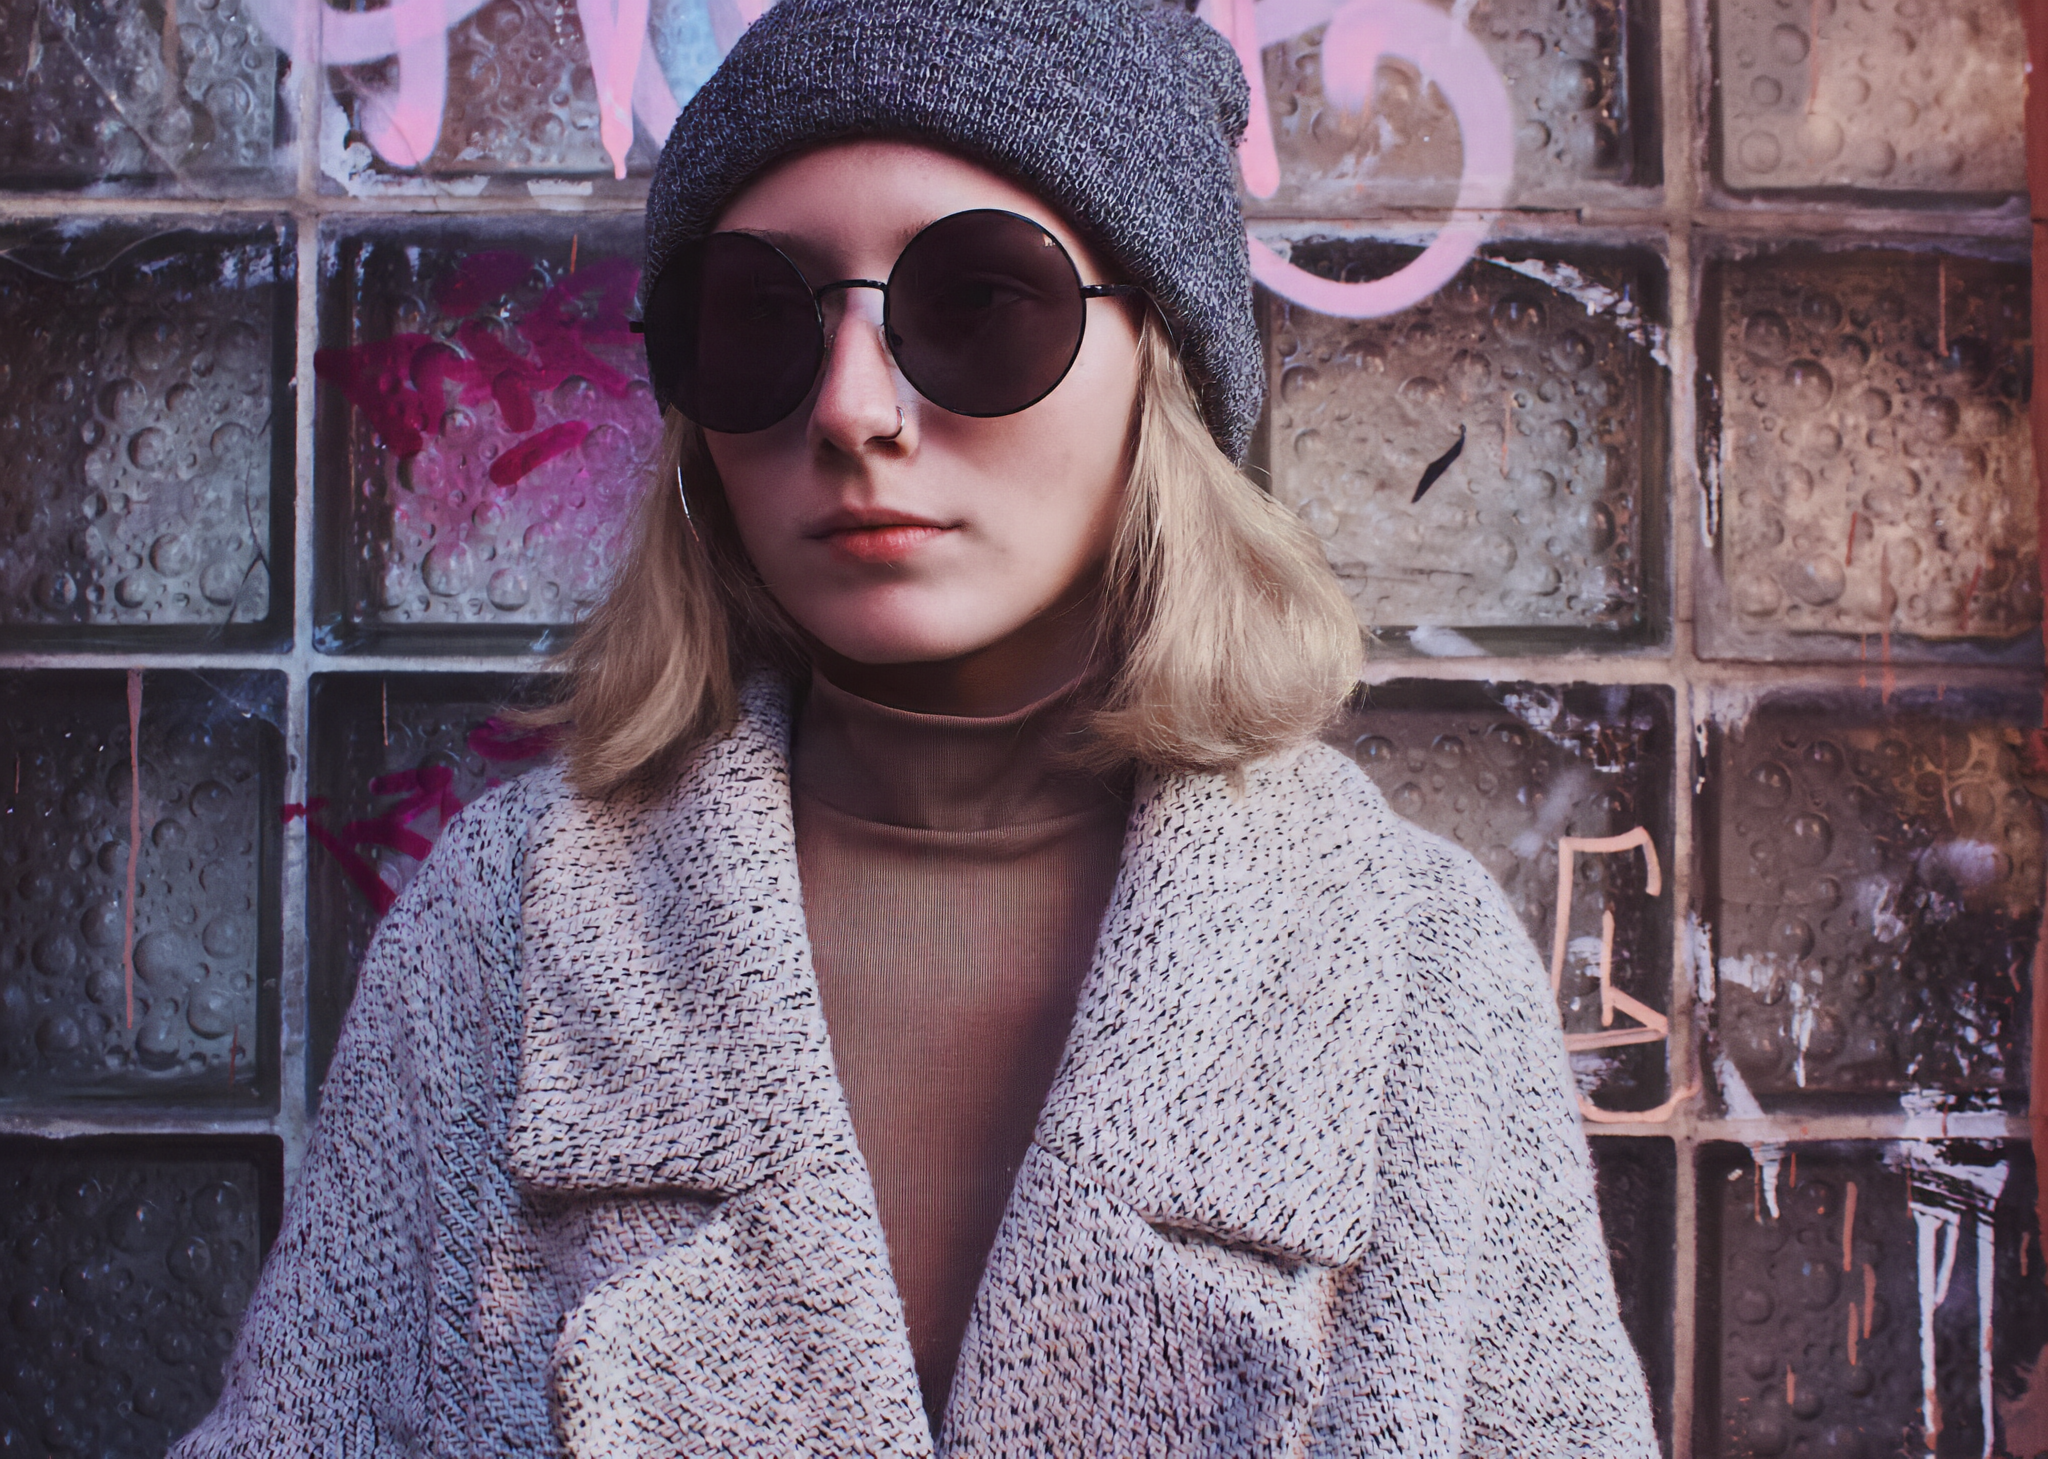

In [26]:
def print_html(html):
    display(HTML(html + '<br/>'))

def make_cell_large():
    display(Javascript(
        '''google.colab.output.setIframeHeight(0, true, {maxHeight: 5192})'''))

make_cell_large()  # Larger output window.

for file in all_outputs:
    print_html('<hr/>')
    file_name, _ = os.path.splitext(file.output_path)
    original_size = original_sizes[os.path.basename(file_name).split('_compressed')[0]]
    print(f'Showing {file.output_path} | {file.num_bytes//1000} kB (compressed) | {file.bpp:.4f} bpp | Original: {original_size//1000} kB')
    display(Image.open(file.output_path))
    print_html('<hr/>')

You can compress new images by going back to the "Prepare Images" heading and selecting a different default image or upload your own for compression, then running the cells below in sequence. Note that each model cannot decompress the output generated by a different model, and you need to delete the contents of `/content/out` if you want to try a different model.

Please open an issue if you encounter an error when running this demo.

In [27]:
from skimage import measure

In [28]:
def get_mse(decoded_img_arr, original_img_arr):
    '''
    The 'Mean Squared Error' between the two images is the
	sum of the squared difference between the two images;
	Note: the two images must have the same dimension
    '''

    mse = np.sum((original_img_arr.astype("float") - decoded_img_arr.astype("float")) ** 2)
    mse /= float(original_img_arr.shape[0] * decoded_img_arr.shape[1])

    # Return the mean-squared-error
    return round(mse, 3)

In [29]:
def ssim_k(original_img_arr, pic_rgb):
    '''
    Calculate Structural Similarity Index (SSIM).
    SSIM is used for measuring the similarity between two images.
    Perceptual metric that quantifies the degradation of images
    Closer to 1 is better
    '''

    return round(measure.compare_ssim(original_img_arr, pic_rgb,  multichannel=True, win_size=3, data_range = 255),3)

In [30]:
make_cell_large()

for file in all_outputs:
    print_html('<hr/>')

    # Extract the unique identifier from the compressed file name
    #identifier = os.path.splitext(os.path.basename(file.output_path))[0].split('_compressed')[0]

    # Construct the original file path based on the unique identifier
    #original_filename = '/content/out/ad249bba099568403dc6b97bc37f8d74_compressed.png'

    # Check if the original file exists
    #if original_filename is None:
     #   print(f"Original file not found for {file.output_path}")
      #  continue

    #file_name = os.path.join(STAGING_DIR, original_filename)

    # Fetch original file size
    #original_size = original_sizes[file_name]

    print(f'Showing {file.output_path} | {file.num_bytes//1000} kB (compressed) | {file.bpp:.4f} bpp | Original: {original_size//1000} kB')

    # Display original and decoded images
    original_img = Image.open('/content/ad249bba099568403dc6b97bc37f8d74.png')
    compressed_img = Image.open('/content/out/ad249bba099568403dc6b97bc37f8d74_compressed.png')

    # Calculate and print MSE and SSIM
    mse = get_mse(np.array(compressed_img), np.array(original_img))
    ssim_value = ssim_k(np.array(original_img), np.array(compressed_img))
    print(f'Mean Squared Error: {mse}')
    print(f'Structural Similarity Index (SSIM): {ssim_value}')

    #display(original_img)
    #display(compressed_img)

    print_html('<hr/>')


<IPython.core.display.Javascript object>

Showing /content/out/ad249bba099568403dc6b97bc37f8d74_compressed.png | 124 kB (compressed) | 0.3339 bpp | Original: 5232 kB
Mean Squared Error: 261.921
Structural Similarity Index (SSIM): 0.824


### Download compressed images

Note: Files are losslessly saved as PNG for viewing.


In [ ]:
download_outputs = True #@param ["False", "True"] {type:"raw"}

In [ ]:
if download_outputs is True:
    ZIP = '/content/hific_compressed_images.zip'

    with zipfile.ZipFile(ZIP, 'w') as zf:
        for f in all_outputs:
            path_with_bpp = f.output_path.replace('.png', f'-{f.bpp:.3f}bpp.png')
            zf.write(f.output_path, os.path.basename(path_with_bpp))

    files.download(ZIP)

# Citation

This is a re-implementation of the orignal paper. Please cite the [original paper](https://arxiv.org/abs/2006.09965) if you use their work.

```bash
@article{mentzer2020high,
  title={High-Fidelity Generative Image Compression},
  author={Mentzer, Fabian and Toderici, George and Tschannen, Michael and Agustsson, Eirikur},
  journal={arXiv preprint arXiv:2006.09965},
  year={2020}
}
```